# Further inspection of recordings showed a third frequency group

#### Before taking more sophisticated approaches towards frequency-based clustering, I felt it would be good to establish a few example recordings represetative of the kinds of frequencies I have observed.

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt
import dask.dataframe as dd

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")

In [3]:
from core import SITE_NAMES, EXAMPLE_FILES_from_LOCATIONS, EXAMPLE_FILES_to_FILEPATHS, EXAMPLE_FILES_to_DETECTIONS
import bout_clustering as bt_clustering
import bout_plotting as bt_plt
import subsampling as ss
import data_handling as dh

from cli import get_file_paths

### Below, red and yellow detections were both originally clustered together as HF calls.
### Blue detections were originally clustered together as LF calls

#### **A white dashed line has been included to show a potential frequency threshold to separate the yellow and red group.**
#### **Calls with min. frequency >= 43000 have been put into the yellow group.**
#### **As an update to the previous notebook, calls with min. frequency >= 35000 have been put into the red group**

In [4]:
def plot_det_groups_over_audio_seg(audio_features, spec_features, plot_dets, data_params, plot_region):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    if data_params['site_key'] == 'Carp' or data_params['site_key'] == 'Central' or data_params['site_key'] == 'Foliage':
        blue_l_bound = 20000
        blue_u_bound = 50000
        red_l_bound = 34000
        red_u_bound = 74000
        yellow_l_bound = 42000
        yellow_u_bound = 92000

    if data_params['site_key'] == 'Telephone':
        blue_l_bound = 20000
        blue_u_bound = 50000
        red_l_bound = 30000
        red_u_bound = 78000
        yellow_l_bound = 41000
        yellow_u_bound = 102000

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(f"BatDetect2 detections on {audio_features['file_path'].name} from {data_params['site_name']}", fontsize=22)
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])
    if plot_region != '':
        if plot_region == 'yellow':
            plt.fill_between(x=np.linspace(0, duration*(fs/2), 11), y1=yellow_l_bound/(fs/2), y2=yellow_u_bound/(fs/2), color='yellow', linewidth=2, alpha=0.5)
        if plot_region == 'red':
            plt.fill_between(x=np.linspace(0, duration*(fs/2), 11), y1=red_l_bound/(fs/2), y2=red_u_bound/(fs/2), color='red', linewidth=2, alpha=0.5)
        if plot_region == 'blue':
            plt.fill_between(x=np.linspace(0, duration*(fs/2), 11), y1=blue_l_bound/(fs/2), y2=blue_u_bound/(fs/2), color='cyan', linewidth=2, alpha=0.5)
    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Group 1')
    red_patch = patches.Patch(facecolor='red', edgecolor='k', label='Group 2')
    blue_patch = patches.Patch(facecolor='cyan', edgecolor='k', label='Group 3')
    legend_patches = [yellow_patch, red_patch, blue_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        if row['freq_group'] == 'HF2':
            rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                            (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                            linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        elif row['freq_group'] == 'HF1':
            rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                            (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                            linewidth=2, edgecolor='red', facecolor='none', alpha=0.8)
        elif row['freq_group'] == 'LF1':
            rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                            (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                            linewidth=2, edgecolor='cyan', facecolor='none', alpha=0.8)
        else:
            rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                            (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                            linewidth=2, edgecolor='yellowgreen', facecolor='none', alpha=0.8)
        ax.add_patch(rect)
    plt.yticks(ticks=np.linspace(0, 1, 7), labels=np.linspace(0, fs/2000, 7).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.xlim(0, duration*(fs/2))
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=20, ncol=int(len(legend_patches)), loc='upper right')

    plt.tight_layout()
    plt.show()


def plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed bouts and bout duurations.
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']
    bci = bout_params['bci']

    plt.figure(figsize=(15, 5))
    plt.title(f"BCI-derived bouts using BD2 detections on {audio_features['file_path'].name}", fontsize=22)
    plt.rcParams.update({'font.size': 24})
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    green_patch = patches.Patch(facecolor='yellowgreen', edgecolor='k', label=f"BCI: {np.round(bci/1000, 2)}s")

    legend_patches = [green_patch]
    ax = plt.gca()
    for i, row in plot_bouts.iterrows():
        plt.text(x=(row['start_time'] - start + (row['bout_duration_in_secs']/5))*(fs/2), y=min((row['high_freq']+2000)/(fs/2), 3/4), 
                            s=f"{round(row['bout_duration_in_secs'], 2)}s", color='pink', fontsize=14)
        if row['freq_group'] == 'HF2':
            rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                            (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                            linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        elif row['freq_group'] == 'HF1':
            rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                            (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                            linewidth=2, edgecolor='red', facecolor='none', alpha=0.8)
        elif row['freq_group'] == 'LF1':
            rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                            (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                            linewidth=2, edgecolor='cyan', facecolor='none', alpha=0.8)
        else:
            rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                            (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                            linewidth=2, edgecolor='yellowgreen', facecolor='none', alpha=0.8)
        ax.add_patch(rect)

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=20, loc='upper right')

    plt.tight_layout()
    plt.show()

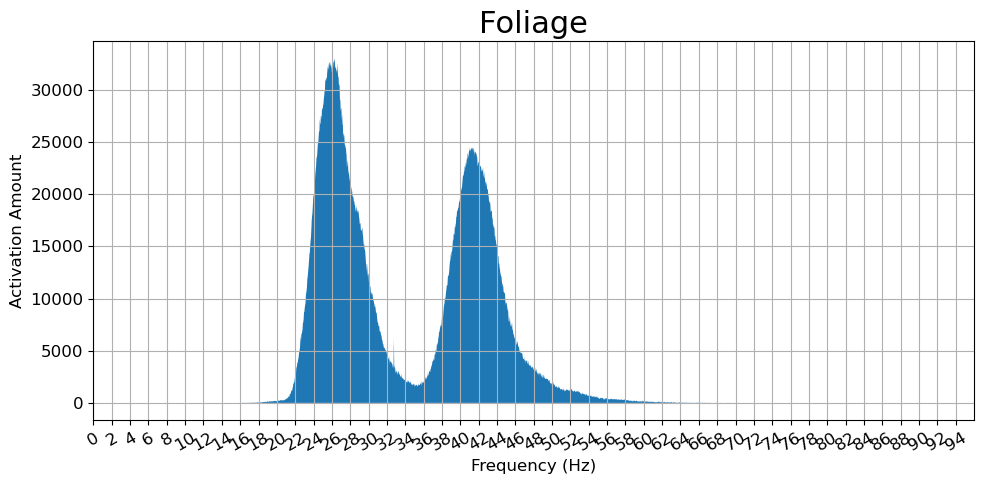

In [5]:
site_key = 'Foliage'
freq_key = ''
files = EXAMPLE_FILES_from_LOCATIONS[site_key]
thresh = -10
line_color = 'navy'
line_alpha = 0.002
reduce = 55
data_params = dict()
data_params["site_name"] = SITE_NAMES[site_key]
data_params["site_tag"] = site_key
spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
fs = 192000

bucket = np.zeros(int(0.025*fs/2)+1)
for filepath_key in files:
    filename = filepath_key.split('/')[-1]
    file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
    audio_file = sf.SoundFile(file_path)
    fs = audio_file.samplerate

    csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
    batdetect2_predictions = dh.assemble_single_bd2_output(csv_path, data_params)


    for i, row in batdetect2_predictions[::].iterrows():

        ########################################################################################################
        ############### BELOW WE READ IN THE WINDOW OF DETECTION OF THE AUDIO WE ARE CONSIDERING ###############
        ########################################################################################################

        start = row['start_time']
        end = row['start_time'] + 0.025
        duration = end - start
        audio_file.seek(int(fs*start))
        audio_seg = audio_file.read(int(fs*duration))

        ################################################################################################
        ############### BELOW WE APPLY A BANDPASS FILTER ON THE AUDIO WE ARE CONSIDERING ###############
        ################################################################################################

        nyq = 0.5 * fs
        low_cutoff = (row['low_freq'] - 2000) / nyq
        high_cutoff =  (row['high_freq'] + 2000) / nyq

        if (row['high_freq'] + 2000 < fs/2):

            b, a = scipy.signal.butter(5, [low_cutoff, high_cutoff], btype='band', analog=False)
            plot_audio_seg = scipy.signal.filtfilt(b, a, audio_seg)

            #####################################################################################
            ############### BELOW WE PLOT THE FFT OF THE AUDIO WE ARE CONSIDERING ###############
            #####################################################################################

            audio_spectrum = scipy.fft.rfft(plot_audio_seg)
            audio_spectrum_abs = np.abs(audio_spectrum)
            frequencies = np.arange(0, len(audio_spectrum_abs))
            audio_spectrum_db =  20*np.log10(audio_spectrum_abs)
            normalized_audio_spectrum_db = audio_spectrum_db - audio_spectrum_db.max()

            thresh = -10
            peak_db = np.zeros(len(normalized_audio_spectrum_db))+thresh
            peak_db[normalized_audio_spectrum_db>=thresh] = 0
            
            bucket[range(0, len(audio_spectrum_db))] += (peak_db-thresh)

plt.figure(figsize=(10, 5))
ft_size = 12
plt.rcParams.update({'font.size':ft_size})
plt.title(f"{SITE_NAMES[site_key]}", fontsize=ft_size+10)

plt.fill_between(np.arange(0, duration*(fs/2)), bucket, 0)
plot_x_ticks = np.arange(0, duration*(fs/2), duration*2000)
plt.xticks(ticks=plot_x_ticks, labels=np.arange(0, fs/2000, 2, dtype='int'), rotation=30)
plt.xlim((0)*duration, (fs/2)*duration)
plt.ylabel("Activation Amount")
plt.xlabel("Frequency (Hz)")
plt.grid(which='both')
plt.tight_layout()
plt.show()

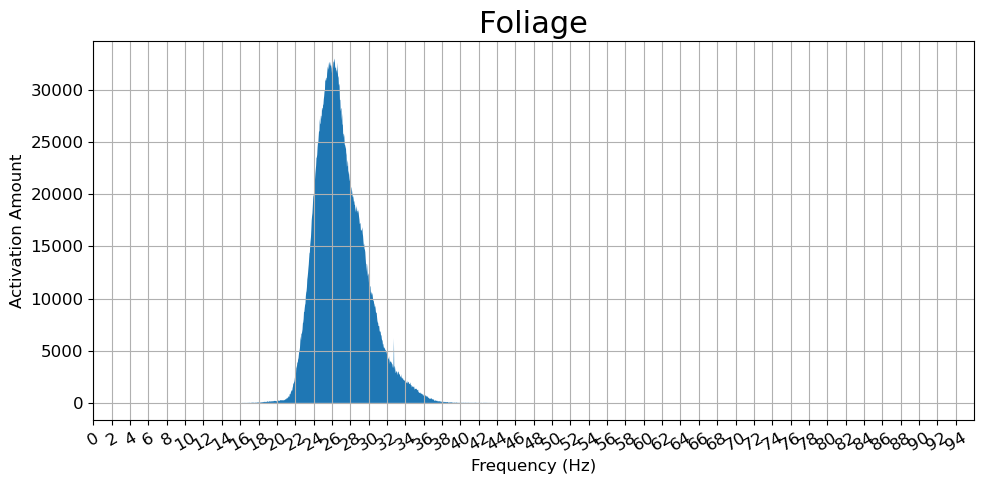

In [6]:
site_key = 'Foliage'
freq_key = 'LF1'
files = EXAMPLE_FILES_from_LOCATIONS[site_key]
thresh = -10
line_color = 'navy'
line_alpha = 0.002
reduce = 55
data_params = dict()
data_params["site_name"] = SITE_NAMES[site_key]
data_params["site_tag"] = site_key
spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
fs = 192000

bucket = np.zeros(int(0.025*fs/2)+1)
for filepath_key in files:
    filename = filepath_key.split('/')[-1]
    file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
    audio_file = sf.SoundFile(file_path)
    fs = audio_file.samplerate

    csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
    batdetect2_predictions = dh.assemble_single_bd2_output(csv_path, data_params)
    selected_calls = batdetect2_predictions.loc[batdetect2_predictions['freq_group']==freq_key]

    for i, row in selected_calls[::].iterrows():

        ########################################################################################################
        ############### BELOW WE READ IN THE WINDOW OF DETECTION OF THE AUDIO WE ARE CONSIDERING ###############
        ########################################################################################################

        start = row['start_time']
        end = row['start_time'] + 0.025
        duration = end - start
        audio_file.seek(int(fs*start))
        audio_seg = audio_file.read(int(fs*duration))

        ################################################################################################
        ############### BELOW WE APPLY A BANDPASS FILTER ON THE AUDIO WE ARE CONSIDERING ###############
        ################################################################################################

        nyq = 0.5 * fs
        low_cutoff = (row['low_freq'] - 2000) / nyq
        high_cutoff =  (row['high_freq'] + 2000) / nyq

        if (row['high_freq'] + 2000 < fs/2):

            b, a = scipy.signal.butter(5, [low_cutoff, high_cutoff], btype='band', analog=False)
            plot_audio_seg = scipy.signal.filtfilt(b, a, audio_seg)

            #####################################################################################
            ############### BELOW WE PLOT THE FFT OF THE AUDIO WE ARE CONSIDERING ###############
            #####################################################################################

            audio_spectrum = scipy.fft.rfft(plot_audio_seg)
            audio_spectrum_abs = np.abs(audio_spectrum)
            frequencies = np.arange(0, len(audio_spectrum_abs))
            audio_spectrum_db =  20*np.log10(audio_spectrum_abs)
            normalized_audio_spectrum_db = audio_spectrum_db - audio_spectrum_db.max()

            thresh = -10
            peak_db = np.zeros(len(normalized_audio_spectrum_db))+thresh
            peak_db[normalized_audio_spectrum_db>=thresh] = 0
            
            bucket[range(0, len(audio_spectrum_db))] += (peak_db-thresh)

plt.figure(figsize=(10, 5))
ft_size = 12
plt.rcParams.update({'font.size':ft_size})
plt.title(f"{SITE_NAMES[site_key]}", fontsize=ft_size+10)

plt.fill_between(np.arange(0, duration*(fs/2)), bucket, 0)
plot_x_ticks = np.arange(0, duration*(fs/2), duration*2000)
plt.xticks(ticks=plot_x_ticks, labels=np.arange(0, fs/2000, 2, dtype='int'), rotation=30)
plt.xlim((0)*duration, (fs/2)*duration)
plt.ylabel("Activation Amount")
plt.xlabel("Frequency (Hz)")
plt.grid(which='both')
plt.tight_layout()
plt.show()

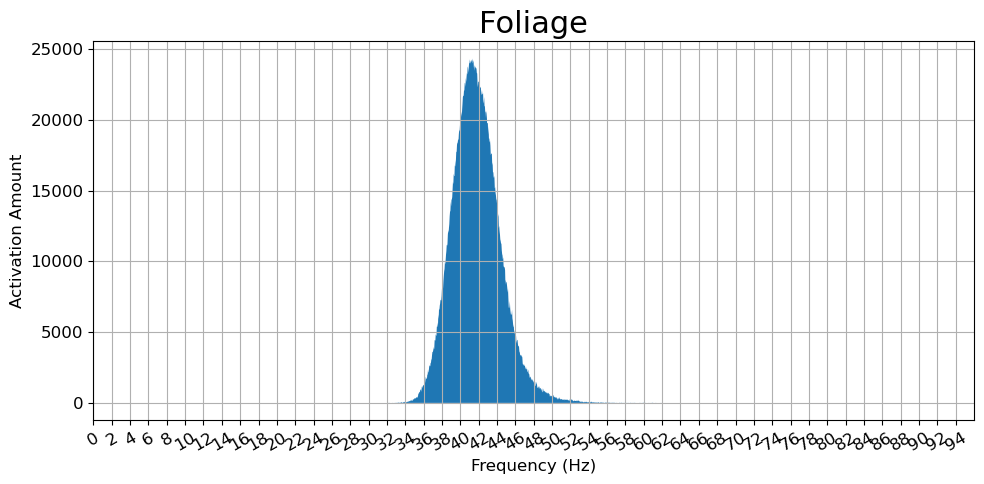

In [7]:
site_key = 'Foliage'
freq_key = 'HF1'
files = EXAMPLE_FILES_from_LOCATIONS[site_key]
thresh = -10
line_color = 'navy'
line_alpha = 0.002
reduce = 55
data_params = dict()
data_params["site_name"] = SITE_NAMES[site_key]
data_params["site_tag"] = site_key
spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
fs = 192000

bucket = np.zeros(int(0.025*fs/2)+1)
for filepath_key in files:
    filename = filepath_key.split('/')[-1]
    file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
    audio_file = sf.SoundFile(file_path)
    fs = audio_file.samplerate

    csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
    batdetect2_predictions = dh.assemble_single_bd2_output(csv_path, data_params)
    selected_calls = batdetect2_predictions.loc[batdetect2_predictions['freq_group']==freq_key]

    for i, row in selected_calls[::].iterrows():

        ########################################################################################################
        ############### BELOW WE READ IN THE WINDOW OF DETECTION OF THE AUDIO WE ARE CONSIDERING ###############
        ########################################################################################################

        start = row['start_time']
        end = row['start_time'] + 0.025
        duration = end - start
        audio_file.seek(int(fs*start))
        audio_seg = audio_file.read(int(fs*duration))

        ################################################################################################
        ############### BELOW WE APPLY A BANDPASS FILTER ON THE AUDIO WE ARE CONSIDERING ###############
        ################################################################################################

        nyq = 0.5 * fs
        low_cutoff = (row['low_freq'] - 2000) / nyq
        high_cutoff =  (row['high_freq'] + 2000) / nyq

        if (row['high_freq'] + 2000 < fs/2):

            b, a = scipy.signal.butter(5, [low_cutoff, high_cutoff], btype='band', analog=False)
            plot_audio_seg = scipy.signal.filtfilt(b, a, audio_seg)

            #####################################################################################
            ############### BELOW WE PLOT THE FFT OF THE AUDIO WE ARE CONSIDERING ###############
            #####################################################################################

            audio_spectrum = scipy.fft.rfft(plot_audio_seg)
            audio_spectrum_abs = np.abs(audio_spectrum)
            frequencies = np.arange(0, len(audio_spectrum_abs))
            audio_spectrum_db =  20*np.log10(audio_spectrum_abs)
            normalized_audio_spectrum_db = audio_spectrum_db - audio_spectrum_db.max()

            thresh = -10
            peak_db = np.zeros(len(normalized_audio_spectrum_db))+thresh
            peak_db[normalized_audio_spectrum_db>=thresh] = 0
            
            bucket[range(0, len(audio_spectrum_db))] += (peak_db-thresh)

plt.figure(figsize=(10, 5))
ft_size = 12
plt.rcParams.update({'font.size':ft_size})
plt.title(f"{SITE_NAMES[site_key]}", fontsize=ft_size+10)

plt.fill_between(np.arange(0, duration*(fs/2)), bucket, 0)
plot_x_ticks = np.arange(0, duration*(fs/2), duration*2000)
plt.xticks(ticks=plot_x_ticks, labels=np.arange(0, fs/2000, 2, dtype='int'), rotation=30)
plt.xlim((0)*duration, (fs/2)*duration)
plt.ylabel("Activation Amount")
plt.xlabel("Frequency (Hz)")
plt.grid(which='both')
plt.tight_layout()
plt.show()

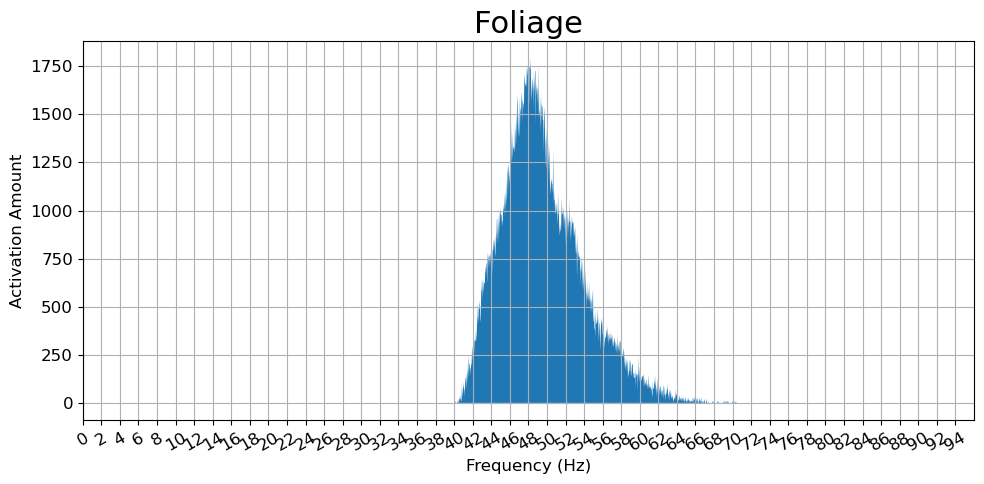

In [8]:
site_key = 'Foliage'
freq_key = 'HF2'
files = EXAMPLE_FILES_from_LOCATIONS[site_key]
thresh = -10
line_color = 'navy'
line_alpha = 0.002
reduce = 55
data_params = dict()
data_params["site_name"] = SITE_NAMES[site_key]
data_params["site_tag"] = site_key
spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
fs = 192000

bucket = np.zeros(int(0.025*fs/2)+1)
for filepath_key in files:
    filename = filepath_key.split('/')[-1]
    file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
    audio_file = sf.SoundFile(file_path)
    fs = audio_file.samplerate

    csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
    batdetect2_predictions = dh.assemble_single_bd2_output(csv_path, data_params)
    selected_calls = batdetect2_predictions.loc[batdetect2_predictions['freq_group']==freq_key]

    for i, row in selected_calls[::].iterrows():

        ########################################################################################################
        ############### BELOW WE READ IN THE WINDOW OF DETECTION OF THE AUDIO WE ARE CONSIDERING ###############
        ########################################################################################################

        start = row['start_time']
        end = row['start_time'] + 0.025
        duration = end - start
        audio_file.seek(int(fs*start))
        audio_seg = audio_file.read(int(fs*duration))

        ################################################################################################
        ############### BELOW WE APPLY A BANDPASS FILTER ON THE AUDIO WE ARE CONSIDERING ###############
        ################################################################################################

        nyq = 0.5 * fs
        low_cutoff = (row['low_freq'] - 2000) / nyq
        high_cutoff =  (row['high_freq'] + 2000) / nyq

        if (row['high_freq'] + 2000 < fs/2):

            b, a = scipy.signal.butter(5, [low_cutoff, high_cutoff], btype='band', analog=False)
            plot_audio_seg = scipy.signal.filtfilt(b, a, audio_seg)

            #####################################################################################
            ############### BELOW WE PLOT THE FFT OF THE AUDIO WE ARE CONSIDERING ###############
            #####################################################################################

            audio_spectrum = scipy.fft.rfft(plot_audio_seg)
            audio_spectrum_abs = np.abs(audio_spectrum)
            frequencies = np.arange(0, len(audio_spectrum_abs))
            audio_spectrum_db =  20*np.log10(audio_spectrum_abs)
            normalized_audio_spectrum_db = audio_spectrum_db - audio_spectrum_db.max()

            thresh = -10
            peak_db = np.zeros(len(normalized_audio_spectrum_db))+thresh
            peak_db[normalized_audio_spectrum_db>=thresh] = 0
            
            bucket[range(0, len(audio_spectrum_db))] += (peak_db-thresh)

plt.figure(figsize=(10, 5))
ft_size = 12
plt.rcParams.update({'font.size':ft_size})
plt.title(f"{SITE_NAMES[site_key]}", fontsize=ft_size+10)

plt.fill_between(np.arange(0, duration*(fs/2)), bucket, 0)
plot_x_ticks = np.arange(0, duration*(fs/2), duration*2000)
plt.xticks(ticks=plot_x_ticks, labels=np.arange(0, fs/2000, 2, dtype='int'), rotation=30)
plt.xlim((0)*duration, (fs/2)*duration)
plt.ylabel("Activation Amount")
plt.xlabel("Frequency (Hz)")
plt.grid(which='both')
plt.tight_layout()
plt.show()

In [9]:
site_key = 'Foliage'
freq_key = ''
files = EXAMPLE_FILES_from_LOCATIONS[site_key]
thresh = -10
line_color = 'navy'
line_alpha = 0.002
reduce = 50
data_params = dict()
data_params["site_name"] = SITE_NAMES[site_key]
data_params["site_tag"] = site_key
data_params["type_tag"] = freq_key
data_params["dc_tag"] = "1800of1800"
data_params["cur_dc_tag"] = "1800of1800"

spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
fs = 192000

file_paths = get_file_paths(data_params)

bucket = np.zeros(int(0.025*fs/2)+1)
filepath_key = files[9]
filename = filepath_key.split('/')[-1]
file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate

csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
batdetect2_predictions_no_dutycycle = dh.assemble_single_bd2_output(csv_path, data_params)
batdetect2_predictions = ss.simulate_dutycycle_on_detections(batdetect2_predictions_no_dutycycle, data_params['cur_dc_tag'])
location_sum_df = dh.assemble_initial_location_summary(data_params, file_paths) 
bout_params = bt_clustering.get_bout_params_from_location(location_sum_df, data_params)
batdetect2_preds_with_bouttags = bt_clustering.classify_bouts_in_bd2_predictions_for_freqgroups(batdetect2_predictions, bout_params)
bout_metrics = bt_clustering.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_preds_with_bouttags)

In [10]:
start = 0
duration = 600
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - reduce # hide anything below -rm_dB dB

bout_params['site_name'] = SITE_NAMES[bout_params['site_key']]
bout_params['bci'] = np.array([bout_params['LF1_bci'], bout_params['HF1_bci'], bout_params['HF2_bci']])

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration
spec_features['vmin'] = vmin

In [11]:
plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

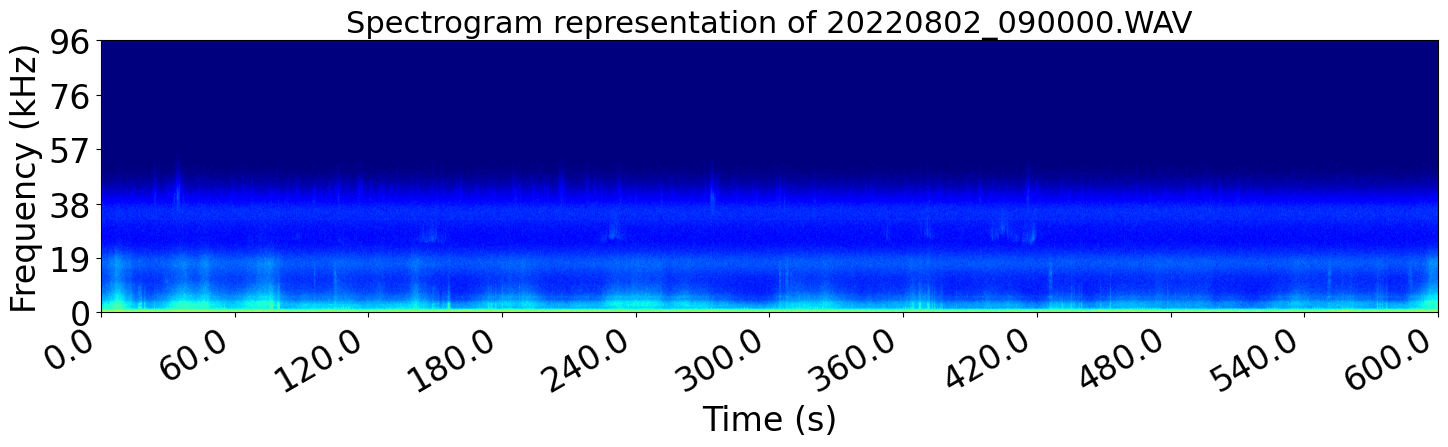

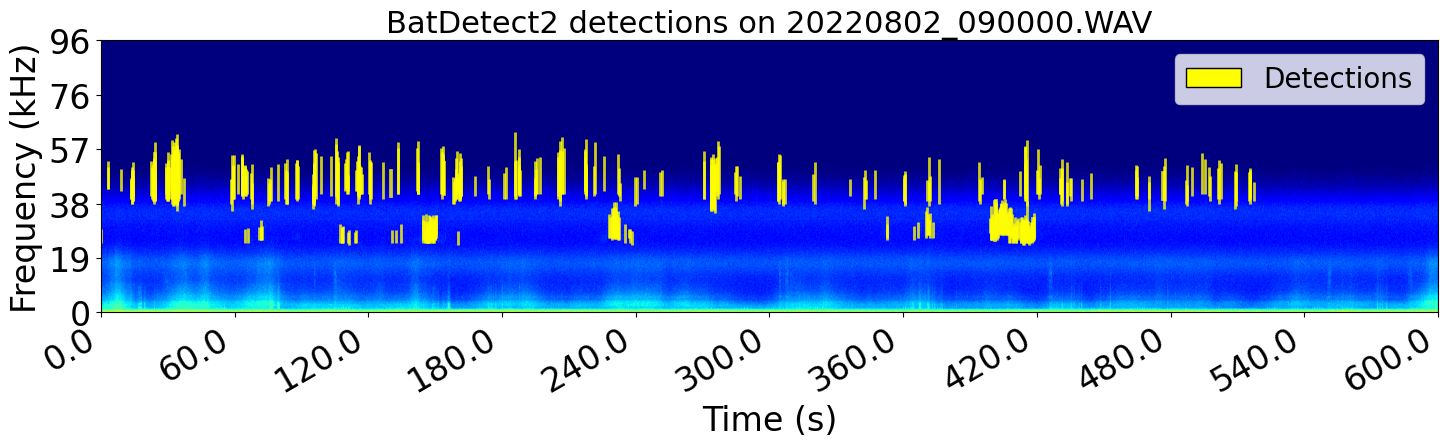

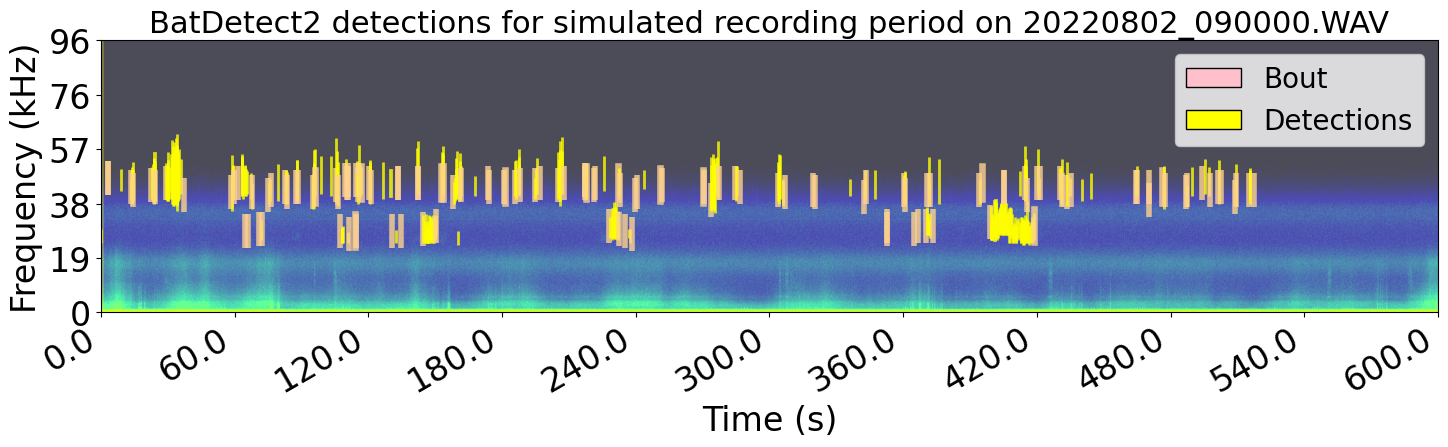

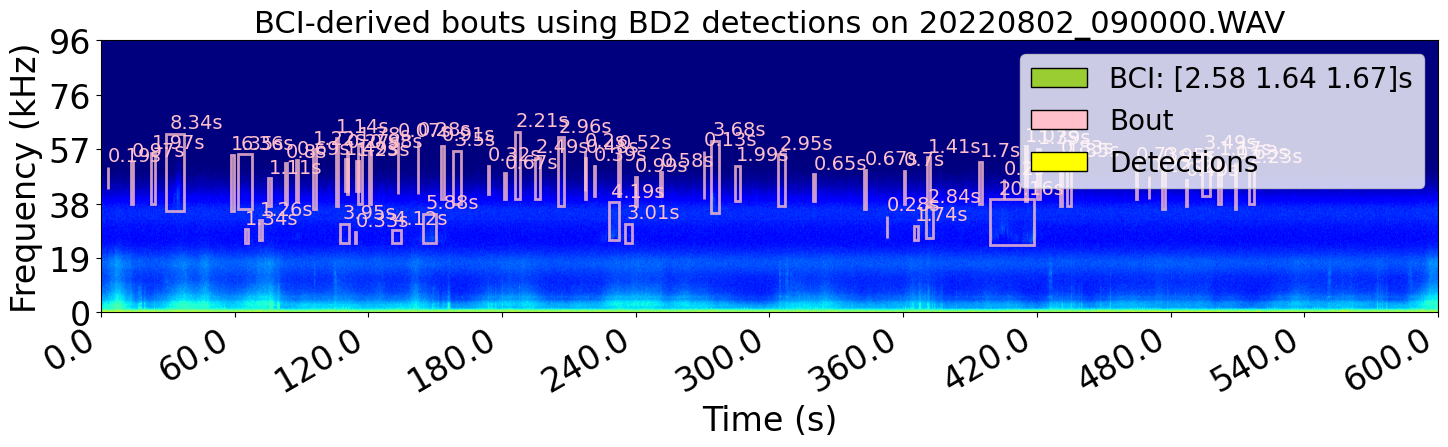

In [12]:
bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle)
bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts)

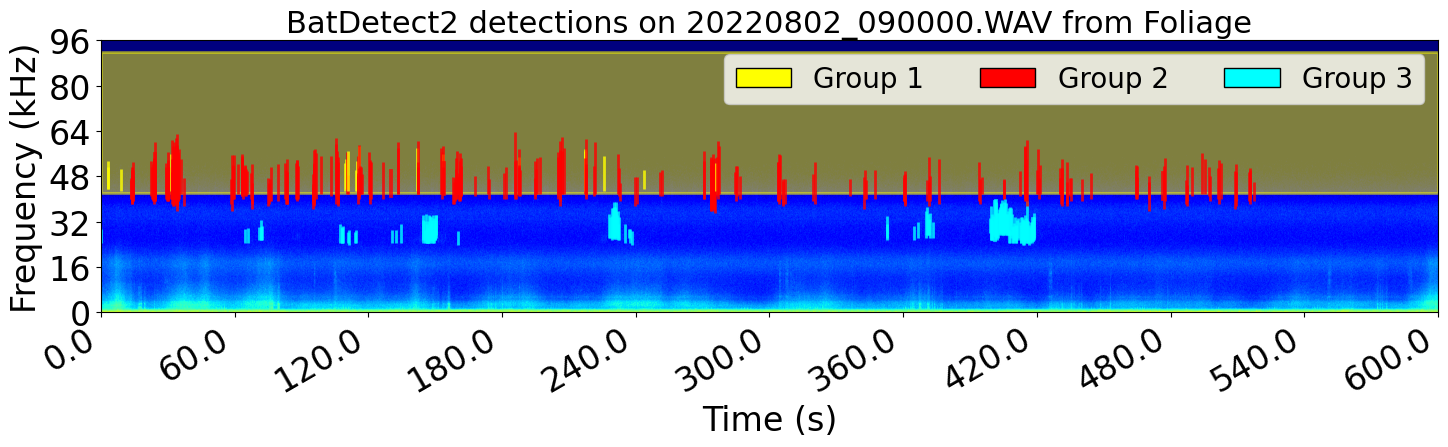

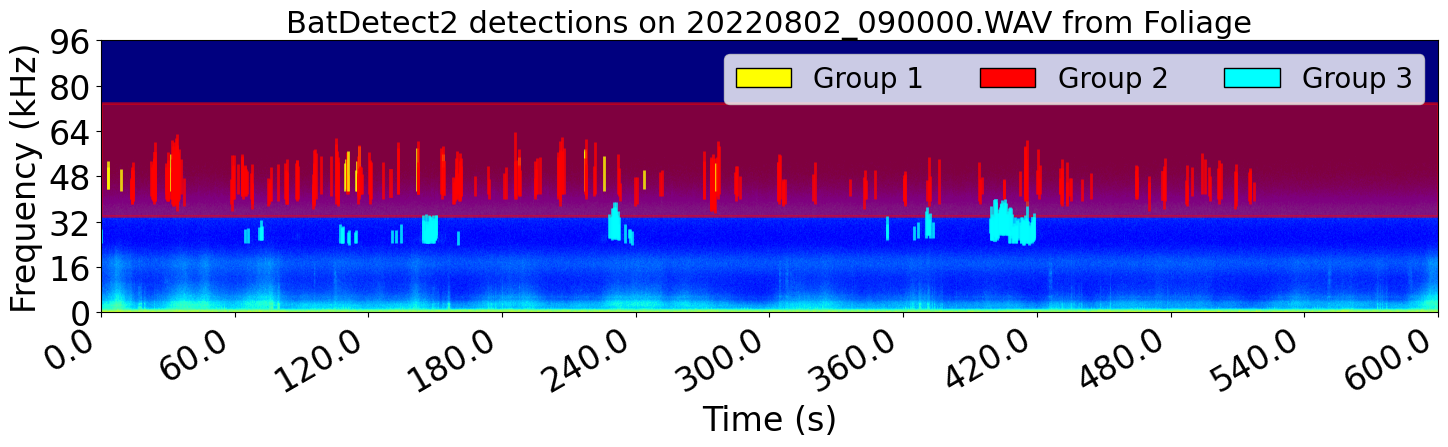

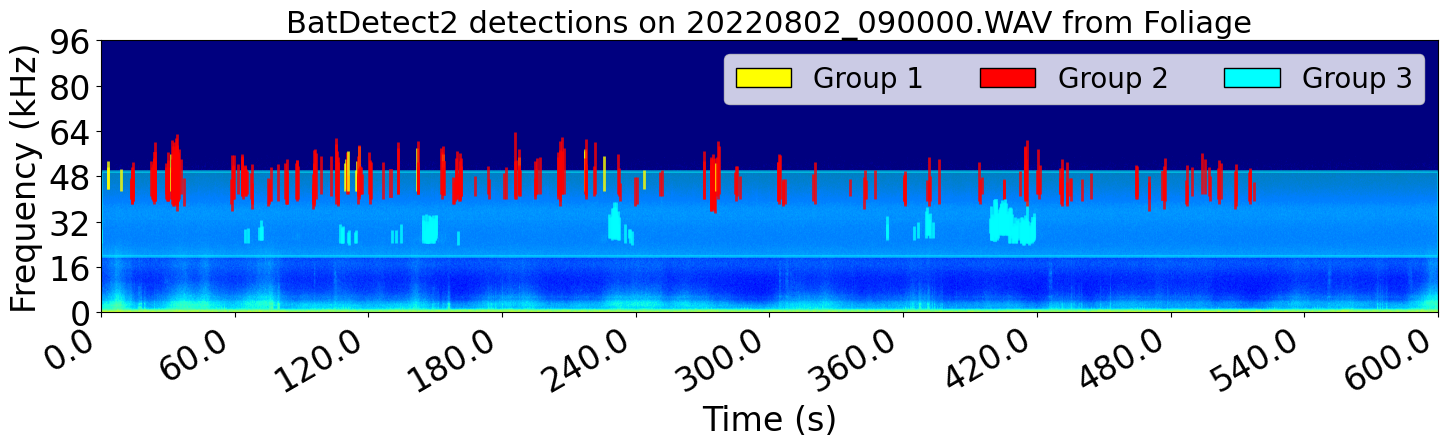

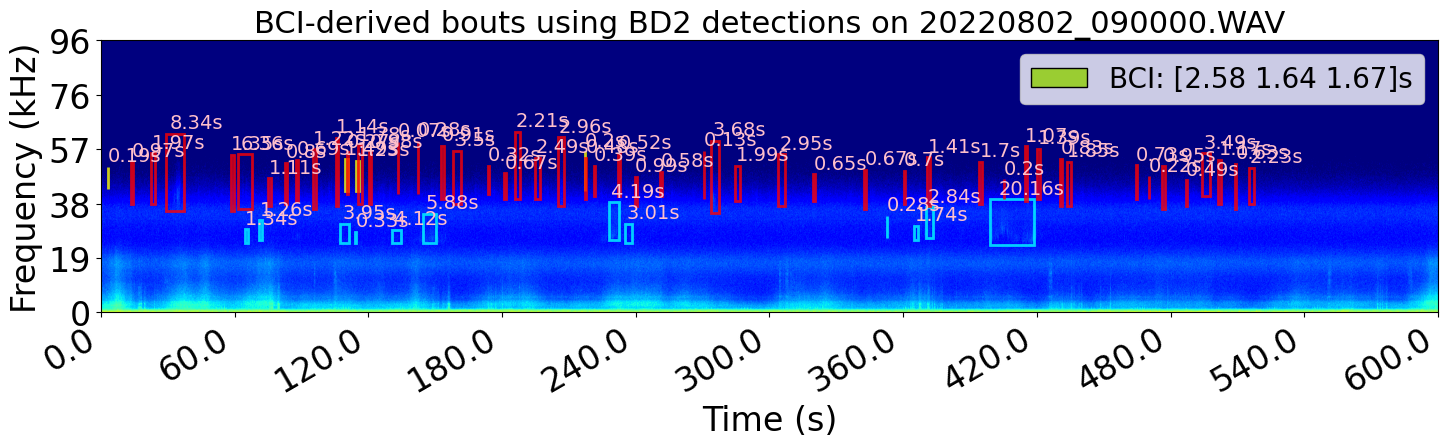

In [13]:
plot_det_groups_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle, bout_params, 'yellow')
plot_det_groups_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle, bout_params, 'red')
plot_det_groups_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle, bout_params, 'blue')
plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts)

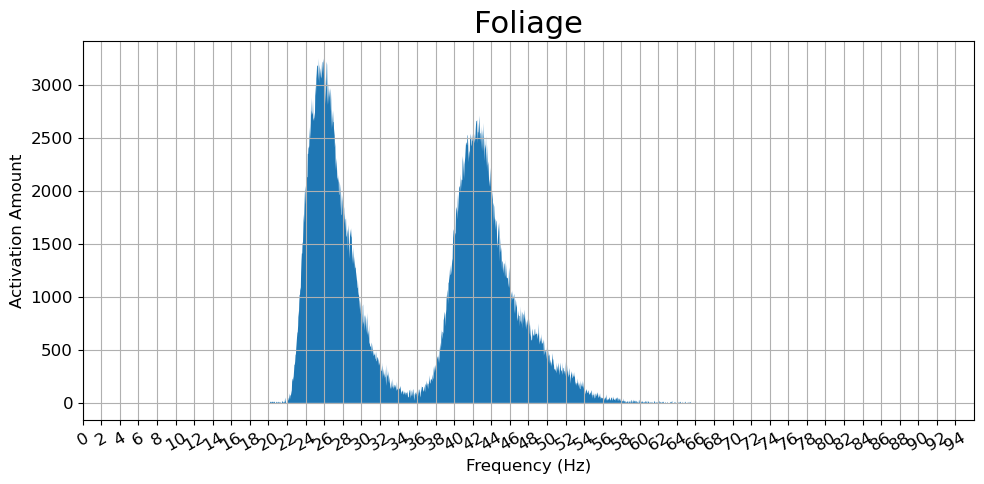

In [14]:
for i, row in batdetect2_predictions[::].iterrows():

    ########################################################################################################
    ############### BELOW WE READ IN THE WINDOW OF DETECTION OF THE AUDIO WE ARE CONSIDERING ###############
    ########################################################################################################

    start = row['start_time']
    end = row['start_time'] + 0.025
    duration = end - start
    audio_file.seek(int(fs*start))
    audio_seg = audio_file.read(int(fs*duration))

    ################################################################################################
    ############### BELOW WE APPLY A BANDPASS FILTER ON THE AUDIO WE ARE CONSIDERING ###############
    ################################################################################################

    nyq = 0.5 * fs
    low_cutoff = (row['low_freq'] - 2000) / nyq
    high_cutoff =  (row['high_freq'] + 2000) / nyq

    if (row['high_freq'] + 2000 < fs/2):

        b, a = scipy.signal.butter(5, [low_cutoff, high_cutoff], btype='band', analog=False)
        plot_audio_seg = scipy.signal.filtfilt(b, a, audio_seg)

        #####################################################################################
        ############### BELOW WE PLOT THE FFT OF THE AUDIO WE ARE CONSIDERING ###############
        #####################################################################################

        audio_spectrum = scipy.fft.rfft(plot_audio_seg)
        audio_spectrum_abs = np.abs(audio_spectrum)
        frequencies = np.arange(0, len(audio_spectrum_abs))
        audio_spectrum_db =  20*np.log10(audio_spectrum_abs)
        normalized_audio_spectrum_db = audio_spectrum_db - audio_spectrum_db.max()

        thresh = -10
        peak_db = np.zeros(len(normalized_audio_spectrum_db))+thresh
        peak_db[normalized_audio_spectrum_db>=thresh] = 0
        
        bucket[range(0, len(audio_spectrum_db))] += (peak_db-thresh)

plt.figure(figsize=(10, 5))
ft_size = 12
plt.rcParams.update({'font.size':ft_size})
plt.title(f"{SITE_NAMES[site_key]}", fontsize=ft_size+10)

plt.fill_between(np.arange(0, len(bucket)), bucket, 0)
plot_x_ticks = np.arange(0, duration*(fs/2), duration*2000)
plt.xticks(ticks=plot_x_ticks, labels=np.arange(0, fs/2000, 2, dtype='int'), rotation=30)
plt.xlim((0)*duration, (fs/2)*duration)
plt.ylabel("Activation Amount")
plt.xlabel("Frequency (Hz)")
plt.grid(which='both')
plt.tight_layout()
plt.show()